### 1) Preprocessing

In [1]:
import os
import shutil
import shap
import numpy as np
import tensorflow as tf
from keras.utils import image_dataset_from_directory, load_img
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, regularizers
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.layers import  Input, Activation, Flatten, Conv2D, MaxPooling2D,  Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import CategoricalCrossentropy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

import cv2
from torchvision.transforms.functional import normalize

 1.1) Loading an image dataset from the 'flowers' directory using the image_dataset_from_directory function. It resizes the images to 128x128 pixels and groups them into batches of 32 images each for easier processing.

In [2]:
data = image_dataset_from_directory(
    'flowers',
    image_size=(128, 128),
    batch_size=32 
)

Found 1517 files belonging to 2 classes.


1.2) Labeling the images into arrays and appends them to the respective listsand normalizing the data, and since the pixel values of the images are normalized by dividing by 255.0, scaling the values to the range [0, 1].

In [3]:
images, labels = [], []
for image, label in data:
    images.append(image.numpy())
    labels.append(label.numpy())
images, labels = np.concatenate(images), np.concatenate(labels)
images /= 255.0

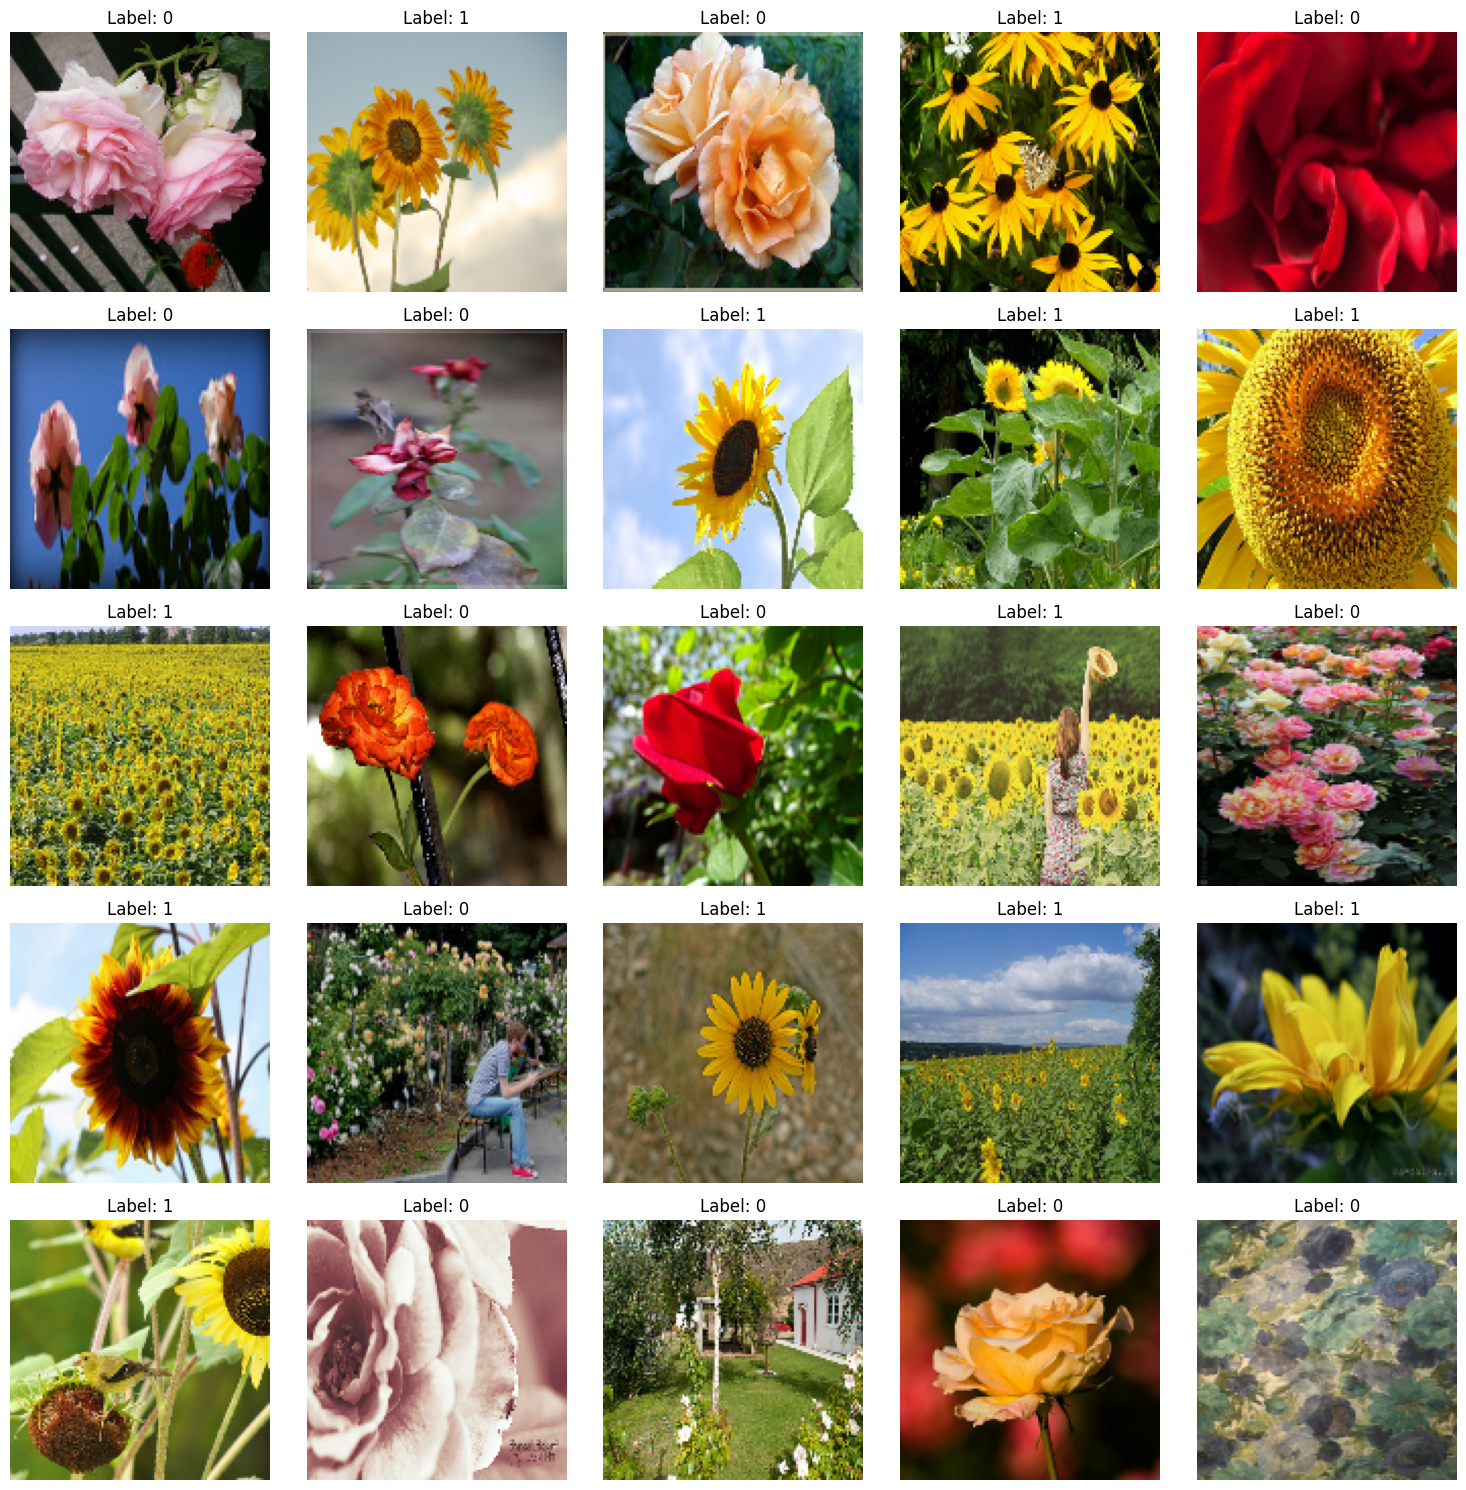

In [4]:
fig, axes = plt.subplots(5, 5, figsize=(15, 15))
axes = axes.flatten()

for i in range(25):
    axes[i].imshow(images[i])
    axes[i].axis('off') 
    axes[i].set_title(f"Label: {labels[i]}")

plt.tight_layout()

### 2) Buidling the model

2.1) Concatenating image and label arrays into training and testing sets using the train_test_split function. 

In [5]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, shuffle=True, random_state=11, stratify=labels)

2.2) Training a convolutional neural network (CNN) for image classification.

**Model Architecture:**
- <u>Input Layer</u>: The model takes input images of shape (128, 128, 3), where 3 represents the RGB color channels.
- <u>Convolutional Layers:</u>
Conv2D layers apply convolution operations, using 32 filters in the first layer and 16 in the second, with a kernel size of 3x3 and ReLU activation.
MaxPooling2D layers downsample the feature maps by a factor of 2.
- <u>Flatten Layer:</u> The output from the convolutional layers is flattened into a 1D vector.
- Dense Layer: A fully connected layer with 3 output units (for 3 classes).
- <u>Softmax Activation:</u>The output layer uses softmax to produce class probabilities.

The model is compiled with the Adam optimizer, and converts the labels to one-hot encoded format for multi-class classification.

The training process uses a batch size of 32, runs for 10 epochs, and uses 15% of the training data for validation.

In [6]:
inputs = Input(shape=(128, 128, 3), name="Input")
x = Conv2D(32, 3, activation="relu", padding='same', name='Conv1')(inputs)
x = MaxPooling2D(2, name='Pool1')(x)
x = Conv2D(16, 3, activation="relu", padding='same', name='Conv2')(x)
x = MaxPooling2D(2, name='Pool2')(x)
x = Flatten(name='Vectorize')(x)
x = Dense(2, name='FC')(x)
outputs = Activation("softmax", name='Softmax')(x)
model = Model(inputs, outputs)
model.compile(optimizer=Adam(learning_rate=0.001), loss=CategoricalCrossentropy(), metrics=['acc'])
model.summary()

hist = model.fit(
    X_train,
    to_categorical(y_train, 2),
    batch_size=32,
    epochs=10,
    validation_split=0.15,
    shuffle='on'
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ Input (InputLayer)              │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv1 (Conv2D)                  │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool1 (MaxPooling2D)            │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv2 (Conv2D)                  │ (None, 64, 64, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Pool2 (MaxPooling2D)            │ (None, 32, 32, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Vectorize (Flatten)             │ (None, 16384)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ FC (Dense)                      │ (None, 2)              │        32,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Softmax (Activation)            │ (None, 2)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,290 (149.57 KB)

 Trainable params: 38,290 (149.57 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 3s 61ms/step - acc: 0.7090 - loss: 0.5494 - val_acc: 0.8713 - val_loss: 0.2946
Epoch 2/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - acc: 0.8916 - loss: 0.2547 - val_acc: 0.8889 - val_loss: 0.2746
Epoch 3/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - acc: 0.9143 - loss: 0.2156 - val_acc: 0.8830 - val_loss: 0.3190
Epoch 4/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - acc: 0.9367 - loss: 0.1698 - val_acc: 0.9006 - val_loss: 0.1965
Epoch 5/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step - acc: 0.9450 - loss: 0.1686 - val_acc: 0.8655 - val_loss: 0.2781
Epoch 6/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - acc: 0.9202 - loss: 0.2047 - val_acc: 0.8830 - val_loss: 0.2640
Epoch 7/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 53ms/step - acc: 0.9592 - loss: 0.1234 - val_acc: 0.8363 - val_loss: 0.3504
Epoch 8/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - acc: 0.9350 - loss: 0.1784 - val_acc: 0.9123 - val_loss: 0.2102
Epoch 9/10
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - acc: 0.9600

2.3) Evaluating the performance of the trained CNN model on the test

In [7]:
y_hat=model.predict(X_test)
print('Acc=',np.sum(y_hat.argmax(1)==y_test)/y_test.shape[0])

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Acc= 0.8921052631578947


### 3) Shap

3.1)  SHAP (SHapley Additive exPlanations) to explain the model's predictions for a specific test image from the dataset. 

- Taking an input x, makes a copy of it, and passes it to the trained model to get predictions.
- Creating a SHAP masker that will generate blurred versions of the input images.

  0%|          | 0/4998 [00:00<?, ?it/s]

PartitionExplainer explainer: 2it [00:10, 10.16s/it]               


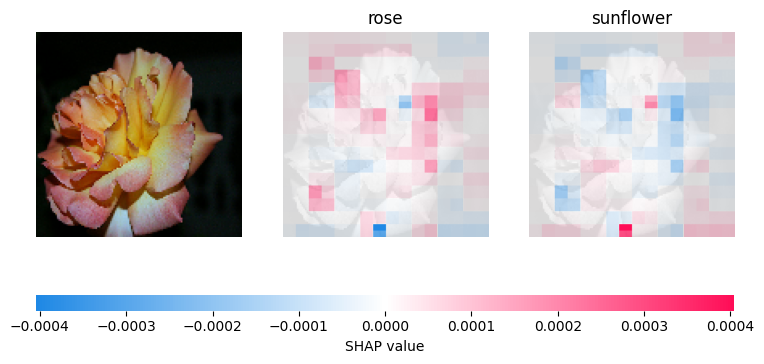

In [8]:
def f(x):
    tmp = x.copy()
    return model(tmp)
masker_blur = shap.maskers.Image("blur(128,128)", X_test[0].shape)
explainer = shap.Explainer(f, masker_blur, output_names=list(range(3)))
ind=[310]
shap_values_ = explainer( X_test[ind], max_evals=5000, batch_size=50 )     
shap.image_plot(shap_values_,labels=['rose','sunflower'])

In [9]:
import os
import torch
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.cluster import KMeans
from torchvision import models, transforms
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt

# Custom GradCAM class
import GradCam

In [26]:
# Directory structure
data_dir = 'flowers'
classes = ['rose', 'sunflower']

# Transformation for ResNet input
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

In [27]:
# Load ResNet model for feature extraction
original_resnet_model = models.resnet50(pretrained=True)
resnet_model = torch.nn.Sequential(*list(original_resnet_model.children())[:-1])

c:\Users\patri\Python\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\patri\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [28]:
# Function to extract embeddings
def get_embedding(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        embedding = model(image).squeeze().numpy()
    return embedding

In [29]:
# Lists to store embeddings and labels
embeddings = []
labels = []
file_paths = []

# Extract embeddings for all images
for label_idx, label_name in enumerate(classes):
    folder_path = os.path.join(data_dir, label_name)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            embedding = get_embedding(img_path, resnet_model, transform)
            embeddings.append(embedding)
            labels.append(label_idx)
            file_paths.append(img_path)
        except Exception as e:
            print(f"Could not process image {img_path}: {e}")

KeyboardInterrupt: 

In [ ]:
# Convert to numpy arrays
embeddings = np.array(embeddings)
labels = np.array(labels)

In [ ]:
# Split the embeddings and labels for training and validation
X_train, X_val, y_train, y_val, paths_train, paths_val = train_test_split(
    embeddings, labels, file_paths, test_size=0.2, random_state=42, stratify=labels
)

In [ ]:
# Train a Random Forest classifier on embeddings
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [ ]:
# Select prototypes for each class using KMeans clustering
n_prototypes = 25
selected_prototypes = {label: [] for label in classes}

for label_idx, label_name in enumerate(classes):
    class_embeddings = embeddings[labels == label_idx]
    class_paths = np.array(file_paths)[labels == label_idx]

    kmeans = KMeans(n_clusters=n_prototypes, random_state=42)
    kmeans.fit(class_embeddings)

    for cluster_center in kmeans.cluster_centers_:
        distances = np.linalg.norm(class_embeddings - cluster_center, axis=1)
        closest_idx = np.argmin(distances)
        selected_prototypes[label_name].append(class_paths[closest_idx])

c:\Users\patri\Python\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\patri\Python\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


In [ ]:
probs = rf_clf.predict_proba(X_val)

# Calculate maximum probabilities for each sample
max_probs = np.max(probs, axis=1)  # Get the highest probability for each sample

# Define the threshold range around 50% (e.g., 45% to 55%)
lower_bound = 0.45
upper_bound = 0.55

# Get indices of samples with probabilities close to 50%
indices_near_50 = np.where((max_probs >= lower_bound) & (max_probs <= upper_bound))[0]

print("Indices of images with probabilities around 50%:", indices_near_50)

# Optionally, you can print additional info about these samples
for idx in indices_near_50:
    print(f"Index: {idx}, Probability: {max_probs[idx]:.2f}, Label: {y_val[idx]}, Predicted: {rf_clf.predict([X_val[idx]])[0]}")

Indices of images with probabilities around 50%: [  2  14  17  32  38  44  58  61  62  67  68  69  71  81  84  85  89  92
 102 103 109 113 114 117 118 123 138 146 153 154 159 163 164 184 185 189
 196 199 206 207 210 214 228 229 230 234 243 246 247 250 254 257 258 276
 277 280 282 291 292 294 301]
Index: 2, Probability: 0.55, Label: 1, Predicted: 0
Index: 14, Probability: 0.51, Label: 1, Predicted: 0
Index: 17, Probability: 0.52, Label: 1, Predicted: 1
Index: 32, Probability: 0.55, Label: 0, Predicted: 0
Index: 38, Probability: 0.51, Label: 1, Predicted: 0
Index: 44, Probability: 0.54, Label: 0, Predicted: 1
Index: 58, Probability: 0.55, Label: 1, Predicted: 0
Index: 61, Probability: 0.55, Label: 1, Predicted: 0
Index: 62, Probability: 0.55, Label: 0, Predicted: 0
Index: 67, Probability: 0.50, Label: 1, Predicted: 0
Index: 68, Probability: 0.54, Label: 1, Predicted: 1
Index: 69, Probability: 0.51, Label: 0, Predicted: 0
Index: 71, Probability: 0.55, Label: 1, Predicted: 0
Index: 81, Pro

Accuracy on validation set: 0.886326194398682
Classification Report:
               precision    recall  f1-score   support

        rose       0.86      0.93      0.89       314
   sunflower       0.91      0.84      0.88       293

    accuracy                           0.89       607
   macro avg       0.89      0.88      0.89       607
weighted avg       0.89      0.89      0.89       607

Confusion Matrix:
 [[291  23]
 [ 46 247]]


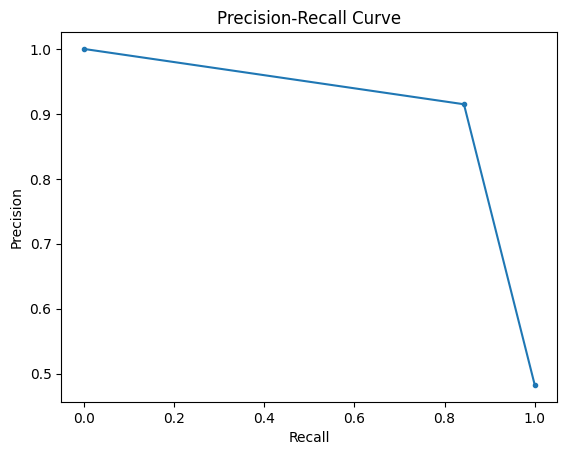

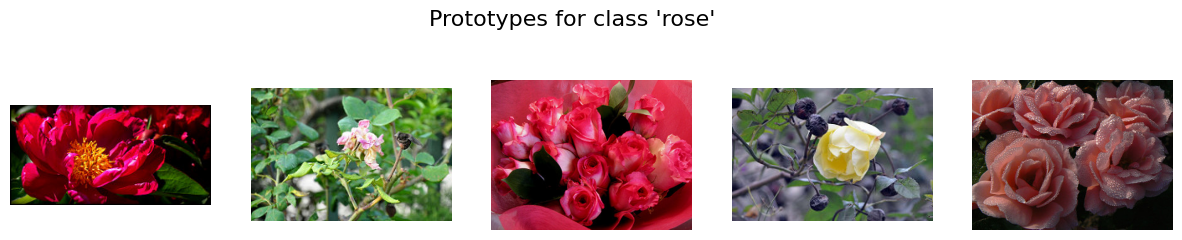

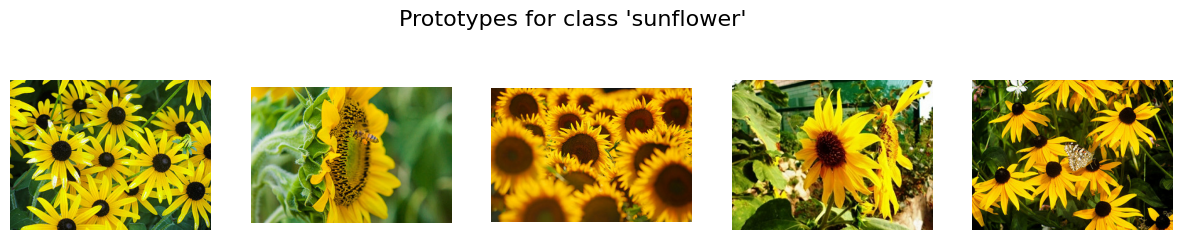

In [55]:
import os
import torch
import numpy as np
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn_extra.cluster import KMedoids  # For better prototype selection
from torchvision import models, transforms
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve

# Data directory and classes
data_dir = 'flowers'
classes = ['rose', 'sunflower']

# Data transformation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Augmentation transformation
augment_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load pre-trained ResNet50 for feature extraction
original_resnet_model = models.resnet50(pretrained=True)
resnet_model = torch.nn.Sequential(*list(original_resnet_model.children())[:-1])

# Function to extract embeddings
def get_embedding(image_path, model, transform):
    image = Image.open(image_path).convert('RGB')
    image = transform(image).unsqueeze(0)
    with torch.no_grad():
        embedding = model(image).squeeze().detach().numpy()  # Add .detach() here
    return embedding


# Extract embeddings
embeddings, labels, file_paths = [], [], []
for label_idx, label_name in enumerate(classes):
    folder_path = os.path.join(data_dir, label_name)
    for img_name in os.listdir(folder_path):
        img_path = os.path.join(folder_path, img_name)
        try:
            embedding = get_embedding(img_path, resnet_model, transform)
            embeddings.append(embedding)
            labels.append(label_idx)
            file_paths.append(img_path)
            augmented_image = augment_transform(Image.open(img_path).convert('RGB'))
            augmented_embedding = resnet_model(augmented_image.unsqueeze(0)).squeeze().detach().numpy()  # Add .detach() here

            embeddings.append(augmented_embedding)
            labels.append(label_idx)
            file_paths.append(img_path + "_augmented")
        except Exception as e:
            print(f"Could not process image {img_path}: {e}")

# Convert to numpy arrays
embeddings = np.array(embeddings)
labels = np.array(labels)

# Train-test split
X_train, X_val, y_train, y_val, paths_train, paths_val = train_test_split(
    embeddings, labels, file_paths, test_size=0.2, random_state=42, stratify=labels
)

# Train Random Forest
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rf_clf.fit(X_train, y_train)

# Validate the classifier
y_pred = rf_clf.predict(X_val)
print("Accuracy on validation set:", accuracy_score(y_val, y_pred))
print("Classification Report:\n", classification_report(y_val, y_pred, target_names=classes))
print("Confusion Matrix:\n", confusion_matrix(y_val, y_pred))

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_val, y_pred, pos_label=1)
plt.plot(recall, precision, marker='.')
plt.title('Precision-Recall Curve')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

# Select prototypes using KMedoids
n_prototypes = 5
selected_prototypes = {label: [] for label in classes}

for label_idx, label_name in enumerate(classes):
    class_embeddings = embeddings[labels == label_idx]
    class_paths = np.array(file_paths)[labels == label_idx]

    kmedoids = KMedoids(n_clusters=n_prototypes, random_state=42)
    kmedoids.fit(class_embeddings)

    for medoid_idx in kmedoids.medoid_indices_:
        selected_prototypes[label_name].append(class_paths[medoid_idx])

# Visualize prototypes
def visualize_prototypes(selected_prototypes, grid_size=(1, 5)):
    for label, prototypes in selected_prototypes.items():
        n_prototypes = len(prototypes)
        rows, cols = grid_size if n_prototypes >= grid_size[1] else (1, n_prototypes)
        
        fig, axes = plt.subplots(rows, cols, figsize=(15, 3), squeeze=False)
        fig.suptitle(f"Prototypes for class '{label}'", fontsize=16)
        
        for idx, prototype_path in enumerate(prototypes):
            image = Image.open(prototype_path.split("_augmented")[0])
            if rows == 1:
                ax = axes[0, idx]
            else:
                ax = axes[idx // cols, idx % cols]
            ax.imshow(image)
            ax.axis('off')
        
        plt.show()

visualize_prototypes(selected_prototypes)


# HERE COMES FOR THE FORMS

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Model Prediction: sunflower


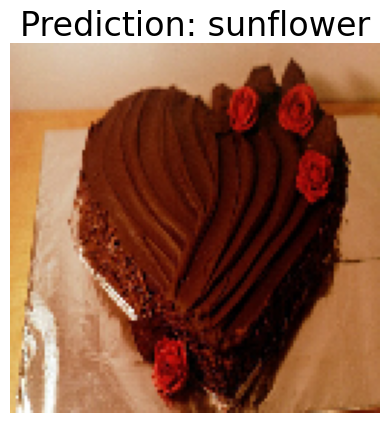

In [76]:
from tensorflow.keras.preprocessing.image import img_to_array

# Select and preprocess the same image for SHAP and Prototype
selected_image_index = 311 # example index, adjust as needed
selected_image = X_test[selected_image_index]

# Model prediction
prediction = model.predict(np.expand_dims(selected_image, axis=0))
predicted_class = np.argmax(prediction)
print(f"Model Prediction: {'rose' if predicted_class == 0 else 'sunflower'}")
plt.imshow(selected_image)
plt.title(f"Prediction: {'rose' if predicted_class == 0 else 'sunflower'}")
plt.axis('off')
plt.show()


  0%|          | 0/4998 [00:00<?, ?it/s]

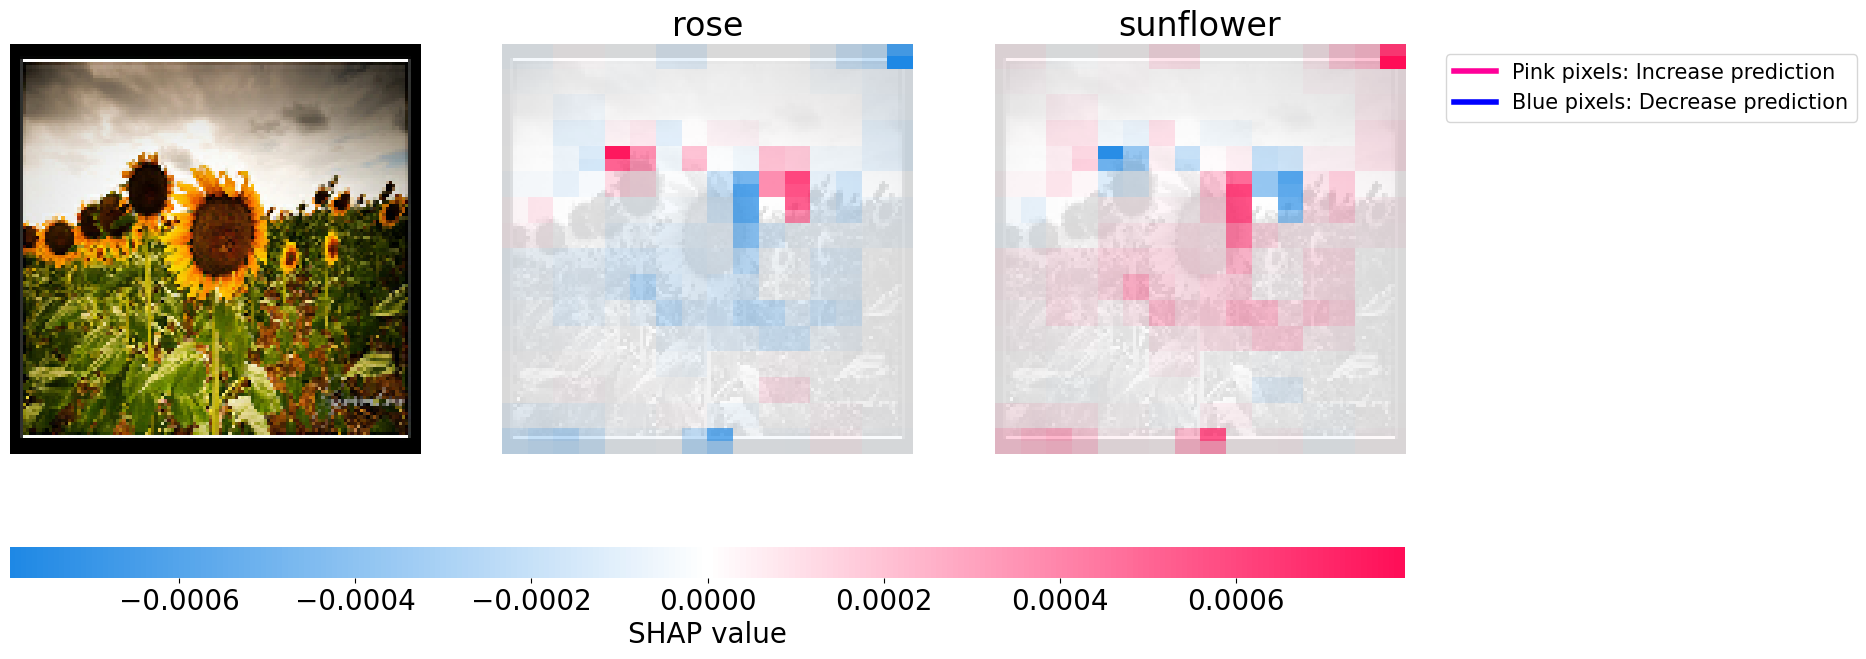

In [69]:
# Generate SHAP explanation
shap_values = explainer(np.expand_dims(selected_image, axis=0), max_evals=5000, batch_size=50)

# Plot without legend
shap.image_plot(shap_values, labels=['rose', 'sunflower'], show=False)

# Create custom legend
from matplotlib.lines import Line2D
legend_elements = [Line2D([0], [0], color='#FF0099', lw=4, label='Pink pixels: Increase prediction'),
                   Line2D([0], [0], color='blue', lw=4, label='Blue pixels: Decrease prediction')]
plt.legend(handles=legend_elements, loc='upper center', bbox_to_anchor=(1.6, 1), fontsize=15)

# Adjust the figure size
plt.gcf().set_size_inches(18, 8)

# Increase the font size of SHAP numbers
plt.rcParams.update({'font.size': 20})

plt.show()

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import torch

# Choose the label name based on the model's predicted class from Question 1
class_name = 'rose' if predicted_class == 0 else 'sunflower'

# Step 1: Find the Closest Prototype
# Use the first prototype for simplicity; adjust this if you'd like to explore other prototypes.
prototype_path = selected_prototypes[class_name][]  # Get the path of the closest prototype
prototype_image = cv2.imread(prototype_path)
prototype_image = cv2.resize(prototype_image, (224, 224))  # Resize prototype to match the display size


plt.figure(figsize=(10, 5))

# Display the Original Image with Prediction Label
plt.subplot(1, 2, 1)
plt.imshow(selected_image)
plt.title(f"Original Image\nPrediction: {class_name.capitalize()}")
plt.axis('off')


# Display the Prototype Image
plt.subplot(1, 2, 2)
plt.imshow(prototype_image[..., ::-1])  # Convert BGR to RGB for display
plt.title("Prototype Image")
plt.axis('off')

plt.show()


error: OpenCV(4.10.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'


indxes used: 32,60, 170,311, 3